# Fama French Five Factor Model

In [4]:
import vectorbt as vbt
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import scipy.stats as stats
import plotly.graph_objects as go
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as fff
from sklearn.linear_model import LinearRegression

In [5]:
# list low volume stocks
# https://finviz.com/screener.ashx?v=111&f=exch_nasd,geo_usa,ipodate_more15&o=volume
# if we were doing more, I would set up API, but this is only 10 stocks
stocks_list = ['SPY', 'INTG', 'HFBL', 'SFBC', 'AIRT', 'EEA', 'CSD', 'GBLI', 'NXN', 'PFIN', 'LINK']
securities = vbt.YFData.download(symbols=stocks_list)
sectors = securities.data.keys()
# create a new column for each sector
df = pd.DataFrame()
for sector in sectors:
  df[sector] = securities.data[sector]['Close']
# make index tz-naive
df.index = df.index.tz_localize(None)
df = df.dropna()

/Users/johnboesen/Documents/Code/#Algotraders/yja/yja-env/lib/python3.9/site-packages/vectorbt/data/base.py:527: UserWarning: Symbols have mismatching index. Setting missing data points to NaN.
  data = cls.align_index(data, missing=missing_index)


In [6]:
def calc_er(df, ticker):
  ff3_monthly = fff.famaFrench3Factor(frequency='m')
  ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
  ff3_monthly.set_index('Date', inplace=True)
  stock_returns = df[ticker].resample('M').last().pct_change().dropna().to_frame(name="Month_Rtn")
  ff_data = ff3_monthly.merge(stock_returns,left_index=True, right_index=True)
  X = ff_data[['Mkt-RF', 'SMB', 'HML']]
  y = ff_data['Month_Rtn'] - ff_data['RF']
  X = sm.add_constant(X)
  ff_model = sm.OLS(y, X).fit()
  intercept, b1, b2, b3 = ff_model.params
  rf = ff_data['RF'].mean()
  market_premium = ff3_monthly['Mkt-RF'].mean()
  size_premium = ff3_monthly['SMB'].mean()
  value_premium = ff3_monthly['HML'].mean()

  expected_monthly_return = rf + b1 * market_premium + b2 * size_premium + b3 * value_premium 
  expected_yearly_return = expected_monthly_return * 12
  return ff_data
calc_er(df, 'INTG')

,Mkt-RF,SMB,HML,RF,Month_Rtn
Date,,,,,
2008-02-29,-0.0309,-0.0043,-0.0084,0.0013,-0.029917
2008-03-31,-0.0093,0.0071,0.0030,0.0017,0.027984
2008-04-30,0.0460,-0.0165,-0.0104,0.0018,0.000000
2008-05-31,0.0186,0.0300,-0.0149,0.0018,0.010556
2008-06-30,-0.0844,0.0120,-0.0267,0.0017,-0.132490
...,...,...,...,...,...
2022-10-31,0.0783,0.0009,0.0805,0.0023,-0.015808
2022-11-30,0.0460,-0.0340,0.0138,0.0029,-0.087845
2022-12-31,-0.0641,-0.0068,0.0132,0.0033,0.024565


In [10]:
# create a new column buy true if actual return over 5 days < expected return
df['buy'] = df['INTG'].pct_change(5) * (365/5) < calc_er('INTG')
# create column sell which is the opposite of buy
df['sell'] = ~df['buy']
# add buy column with true if delta_nice > 0
# df = df[df.index.year == 2016]
# create portfolio and run backtest
portfolio = vbt.Portfolio.from_signals(df['SPY'], df.buy, df.sell, freq='D', )
portfolio.stats()

Start                               2008-01-09 05:00:00
End                                 2023-03-24 04:00:00
Period                               3829 days 00:00:00
Start Value                                       100.0
End Value                                    165.433476
Total Return [%]                              65.433476
Benchmark Return [%]                         279.923515
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              38.041944
Max Drawdown Duration                1377 days 00:00:00
Total Trades                                        500
Total Closed Trades                                 500
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                       60.6
Best Trade [%]                                 7.512568
Worst Trade [%]                               -1

In [11]:
portfolio.plot().show()

In [11]:
df.head()

,SPY,INTG,HFBL,SFBC,AIRT,EEA,CSD,GBLI,NXN,PFIN,LINK
Date,,,,,,,,,,,
2008-01-09 05:00:00,104.165718,18.290001,3.482935,7.326816,4.819349,6.789409,20.534878,33.486553,7.258773,4.657256,7.2
2008-01-10 05:00:00,104.848412,18.290001,3.482935,7.693157,4.841609,6.795183,20.927052,33.221973,7.355061,4.741933,7.4
2008-01-11 05:00:00,104.002457,18.290001,3.482935,7.693157,4.952910,6.673945,20.334620,31.750214,7.323383,5.368545,7.4
2008-01-14 05:00:00,104.840981,17.910000,3.486603,7.326816,4.980736,6.714356,20.534878,32.477825,7.366332,5.504028,7.4
2008-01-15 05:00:00,102.533127,18.020000,3.482935,7.326816,4.925085,6.518064,20.017538,32.725872,7.355595,5.588707,7.2


In [12]:
df.head()
df.dropna()

def calc_er(ticker, alpha=0.9):
    global df
    ff3_monthly = fff.famaFrench3Factor(frequency='m')
    ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
    ff3_monthly.set_index('Date', inplace=True)
    
    stock_returns = df[ticker].resample('M').last().pct_change().dropna().to_frame(name="Month_Rtn")
    stock_returns['Expected_Rtn'] = 0.0

    df['market_premium'] = [np.nan] * len(df)
    df['size_premium'] = [np.nan] * len(df)
    df['value_premium'] = [np.nan] * len(df)
    df['RF'] = [np.nan] * len(df)
    df['y'] = [np.nan] * len(df)
    # print variance in ff3 columns
    
    for i, date in enumerate(stock_returns.index):
        # calculate the weights for each observation
        weights = alpha ** (len(stock_returns) - i - 1 - np.arange(len(stock_returns)))
        
        # select the relevant rows from the factor data and adjust weights
        relevant_ff3 = ff3_monthly.loc[:date]
        relevant_weights = weights[-len(relevant_ff3):]
        
        # calculate the expected returns using the weighted factors
        relevant_ff3 = relevant_ff3.tail(len(relevant_weights))
        relevant_ff3['weighted_Mkt-RF'] = relevant_ff3['Mkt-RF'] * relevant_weights
        # on each iteration, check that date is in the ff3_monthly df and stock_returns df
        if date not in ff3_monthly.index or date not in stock_returns.index:
            continue
        # print('we here')
        df.loc[date, 'market_premium'] = relevant_ff3['weighted_Mkt-RF'].mean()
        df.loc[date, 'size_premium'] = (relevant_ff3['SMB'] * relevant_weights).mean()
        df.loc[date, 'value_premium'] = (relevant_ff3['HML'] * relevant_weights).mean()
        df.loc[date, 'RF'] = relevant_ff3['RF'][date]
        df.loc[date, 'y'] = stock_returns['Month_Rtn'][date] - relevant_ff3['RF'][date]
    
    # fill in null rows of x with mean of next and previous nonnull values
    # df['market_premium'] = df['market_premium'].fillna(method='ewm')
    df['market_premium'] = df['market_premium'].interpolate(method='linear', axis=0).ffill().bfill()
    df['size_premium'] = df['size_premium'].interpolate(method='linear', axis=0).ffill().bfill()
    df['value_premium'] = df['value_premium'].interpolate(method='linear', axis=0).ffill().bfill()
    df['RF'] = df['RF'].fillna(df['RF'].interpolate(method='linear', axis=0).ffill().bfill())
    df['y'] = df['y'].fillna(df['y'].interpolate(method='linear', axis=0).ffill().bfill())
    # get null values of x
    # print(X[X.notnull().any(axis=0)])
    # cut off dates before 2008-01-09 05:00:00
    df = df[df.index >= '2008-01-09 05:00:00']

calc_er('INTG')

Mkt-RF    0.002865
SMB       0.001005
HML       0.001269
RF        0.000006
dtype: float64
(4015, 16) (182, 2) (1160, 4)


<AxesSubplot: xlabel='Date'>

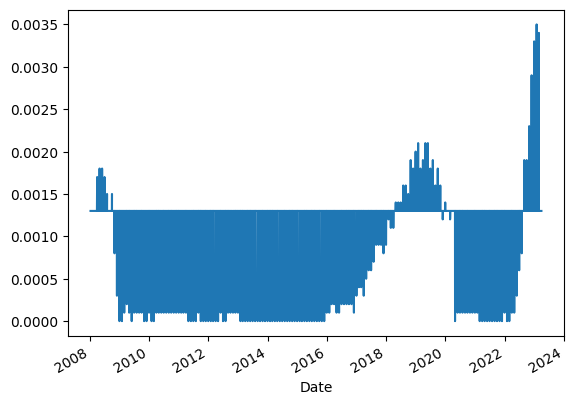

In [11]:
# graph df['RF'] column
df['RF'].plot()

In [19]:
def get_coefs(ticker):
  global df
  y = df['y']
  X = df[['market_premium', 'size_premium', 'value_premium']]
  # get all x rows with no null values
  print(X[X.notnull().any(axis=1)])
  ff_model = sm.OLS(y, X).fit()
  print(ff_model.summary())
  b1, b2, b3 = ff_model.params
  expected_monthly_return = df['RF'] + b1 * df['market_premium'] + b2 * df['size_premium'] + b3 * df['value_premium']

  # update the expected returns column with the latest prediction
  df[f'{ticker}_Expected_Rtn'] = expected_monthly_return / 30
  return expected_monthly_return
get_coefs('INTG')

                     market_premium  size_premium  value_premium
Date                                                            
2008-01-09 05:00:00       -0.000415     -0.000329      -0.000248
2008-01-10 05:00:00       -0.000415     -0.000329      -0.000248
2008-01-11 05:00:00       -0.000415     -0.000329      -0.000248
2008-01-14 05:00:00       -0.000415     -0.000329      -0.000248
2008-01-15 05:00:00       -0.000415     -0.000329      -0.000248
...                             ...           ...            ...
2022-09-30 00:00:00   -64373.502039  -4801.646077   56507.554871
2022-10-31 00:00:00   -15731.805664  -4242.546115  106515.940115
2022-11-30 00:00:00    16019.549907 -27710.939369  116041.346890
2022-12-31 00:00:00   -33141.365588 -32926.137890  126164.967651
2023-01-31 00:00:00    23527.049861   9937.340233   91396.977577

[4009 rows x 3 columns]
                                 OLS Regression Results                                
Dep. Variable:                      y   R-

Date
2008-01-09 05:00:00    0.001300
2008-01-10 05:00:00    0.001300
2008-01-11 05:00:00    0.001300
2008-01-14 05:00:00    0.001300
2008-01-15 05:00:00    0.001300
                         ...   
2022-09-30 00:00:00   -0.047138
2022-10-31 00:00:00   -0.011061
2022-11-30 00:00:00   -0.018740
2022-12-31 00:00:00   -0.058726
2023-01-31 00:00:00    0.035185
Length: 4009, dtype: float64

<AxesSubplot: xlabel='Date'>

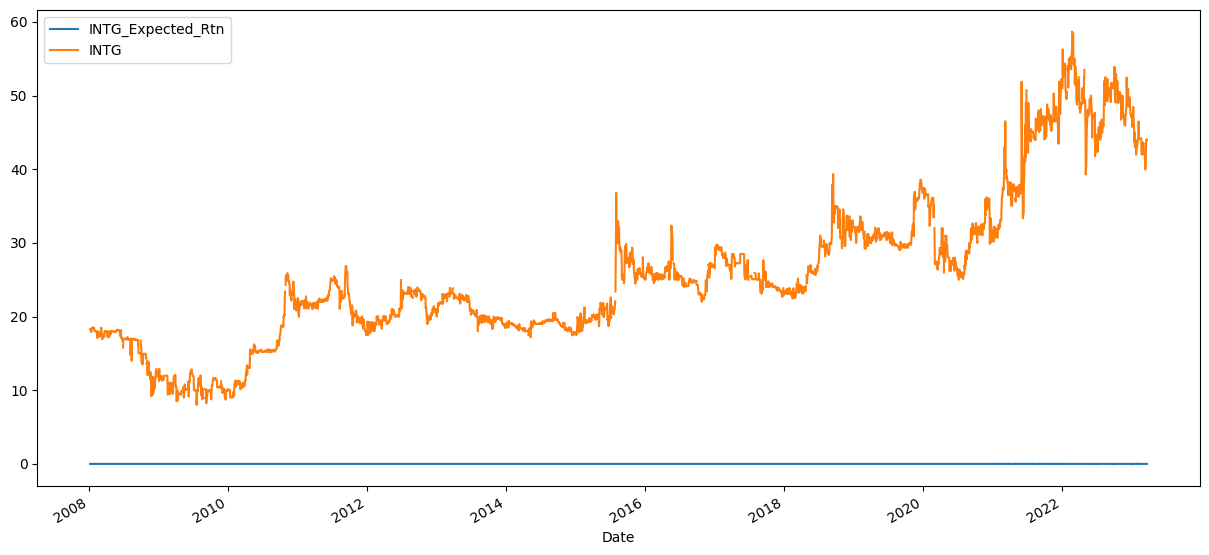

In [20]:
# plot expected returns versus actual returns
df[['INTG_Expected_Rtn', 'INTG']].plot(figsize=(15, 7))